Trial 30 Complete [00h 00m 20s]
val_loss: 0.0003383540897630155

Best val_loss So Far: 0.00016430731920991093
Total elapsed time: 00h 05m 55s
INFO:tensorflow:Oracle triggered exit
🔧 En iyi hiperparametreler:
units_1: 64
units_2: 128
dropout_1: 0.2
dropout_2: 0.30000000000000004
optimizer: adam
Epoch 1/50
83/83 [==============================] - 5s 24ms/step - loss: 2.5072e-04 - val_loss: 0.0576
Epoch 2/50
83/83 [==============================] - 1s 9ms/step - loss: 1.4532e-05 - val_loss: 3.8691e-04
Epoch 3/50
83/83 [==============================] - 1s 10ms/step - loss: 4.4225e-06 - val_loss: 6.1661e-04
Epoch 4/50
83/83 [==============================] - 1s 13ms/step - loss: 3.9335e-06 - val_loss: 2.4516e-04
Epoch 5/50
83/83 [==============================] - 1s 10ms/step - loss: 3.7837e-06 - val_loss: 6.4118e-04
Epoch 6/50
83/83 [==============================] - 1s 10ms/step - loss: 4.6903e-06 - val_loss: 7.3693e-04
Epoch 7/50
83/83 [==============================] - 1s 10ms/step - l

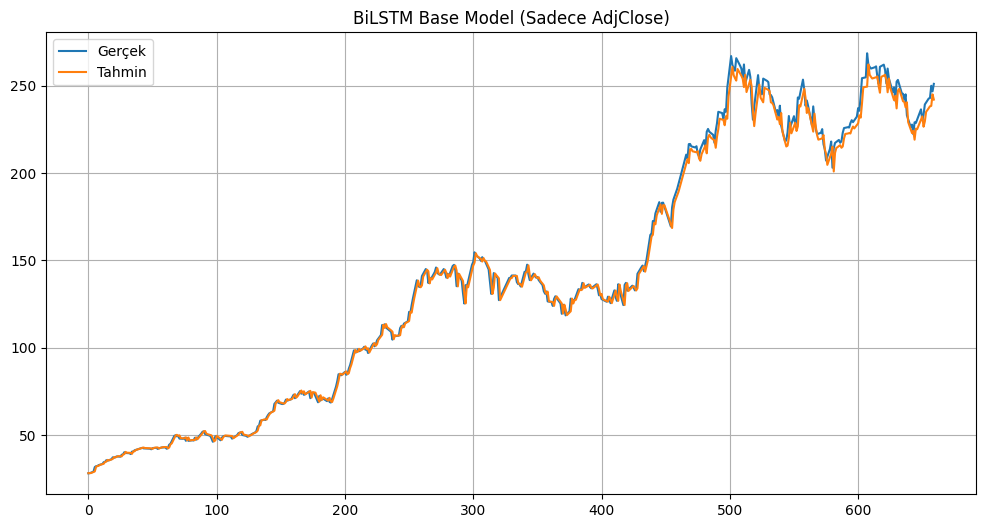

C:\Users\onugu\AppData\Local\Temp\ipykernel_31240\2101438218.py:128: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last6m = data.last('6M')
C:\Users\onugu\AppData\Local\Temp\ipykernel_31240\2101438218.py:128: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last6m = data.last('6M')


📸 Grafik kaydedildi: plots/BiLSTM_base_result_last6M_2025-04-06_06-17-47.png


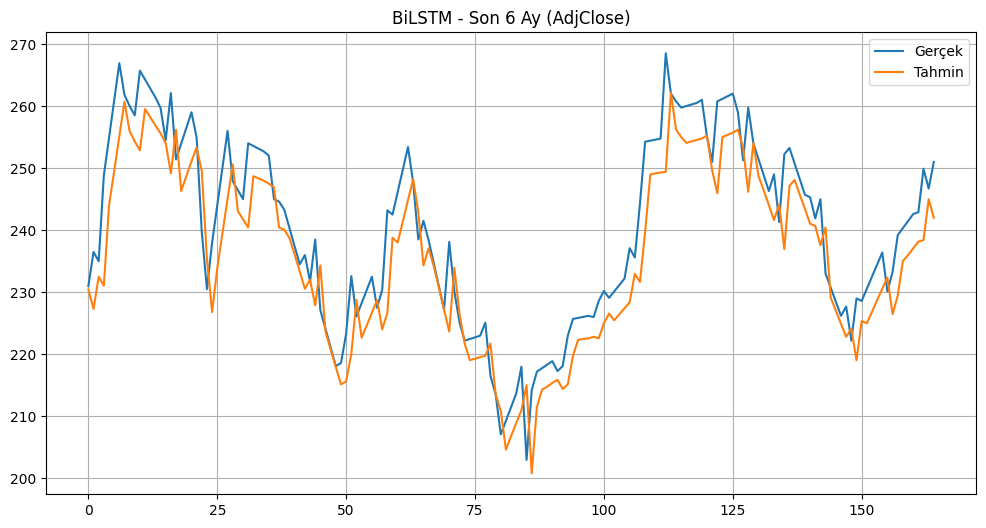

21/21 [==============================] - 0s 5ms/step

📊 Özellik Önem Sıralaması (Permutation Importance):
AdjClose: Önem Skoru = 0.378496


In [1]:
# %%
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras_tuner import Hyperband
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import copy
from log_record import log_model_report, save_plot

# 🚀 GPU kontrol
print("📦 TensorFlow:", tf.__version__)
print("🧠 GPU:", tf.test.gpu_device_name())

# 📥 Veri yükleme
data = pd.read_csv("Merged_Data.csv", parse_dates=['Tarih'], index_col='Tarih', sep=',', decimal='.')
data = data.drop(columns=["Hacim", "Fark%", "GDP"], errors='ignore')
data.dropna(inplace=True)

# Özellik ve hedef
feature_names = ['AdjClose']  # gerekli log için
X_all = data[feature_names].values
y_all = data[['AdjClose']].values

# Ölçekleme
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_all)
y_scaled = scaler_y.fit_transform(y_all)

# Sekans oluşturma
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 1
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Eğitim/test böl
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 🧠 BiLSTM Model fonksiyonu
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units_1', 32, 128, step=32),
                                 return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(Bidirectional(LSTM(units=hp.Int('units_2', 32, 128, step=32),
                                 return_sequences=False)))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='mean_squared_error')
    return model

# 🔍 Tuner başlat
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='tuner_logs',
    project_name='bilstm_base_adjclose'
)

# 🔄 Tuner eğitimi
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             verbose=1)

# 🎯 En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("🔧 En iyi hiperparametreler:")
for param in ['units_1', 'units_2', 'dropout_1', 'dropout_2', 'optimizer']:
    print(f"{param}: {best_hps.get(param)}")

# 🧠 Final BiLSTM modelini oluştur
final_model = Sequential()
final_model.add(Bidirectional(LSTM(units=best_hps.get('units_1'), return_sequences=True),
                              input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(best_hps.get('dropout_1')))
final_model.add(Bidirectional(LSTM(units=best_hps.get('units_2'), return_sequences=False)))
final_model.add(Dropout(best_hps.get('dropout_2')))
final_model.add(Dense(1))
final_model.compile(optimizer=best_hps.get('optimizer'), loss='mean_squared_error')

# 🛑 EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 🚀 Model eğitimi
history = final_model.fit(X_train, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test, y_test),
                          callbacks=[early_stop], verbose=1)

# 📈 Tahmin ve De-Scale
y_pred_scaled = final_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# 📊 Performans
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100
print("✅ RMSE:", rmse)
print("📉 MAPE: %.2f%%" % mape)

# 🖼️ Grafik: Genel
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Gerçek')
plt.plot(y_pred, label='Tahmin')
plt.title('BiLSTM Base Model (Sadece AdjClose)')
plt.legend()
plt.grid(True)
save_plot("BiLSTM_base_result")
plt.show()

# 🖼️ Grafik: Son 6 Ay
last6m = data.last('6M')
last_n = len(last6m)
y_test_last6m = y_test_inv[-last_n:]
y_pred_last6m = y_pred[-last_n:]

plt.figure(figsize=(12, 6))
plt.plot(y_test_last6m, label='Gerçek')
plt.plot(y_pred_last6m, label='Tahmin')
plt.title('BiLSTM - Son 6 Ay (AdjClose)')
plt.legend()
plt.grid(True)
save_plot("BiLSTM_base_result_last6M")
plt.show()

# 🔍 Feature Importance (Permutation)
baseline_pred = final_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
feature_importances = []

for i in range(X_test.shape[2]):
    X_test_copy = copy.deepcopy(X_test)
    np.random.shuffle(X_test_copy[:, :, i])
    shuffled_pred = final_model.predict(X_test_copy)
    shuffled_rmse = np.sqrt(mean_squared_error(y_test, shuffled_pred))
    importance = shuffled_rmse - baseline_rmse
    feature_importances.append((feature_names[i], importance))

feature_importances.sort(key=lambda x: x[1], reverse=True)
print("\n📊 Özellik Önem Sıralaması (Permutation Importance):")
for feat, imp in feature_importances:
    print(f"{feat}: Önem Skoru = {imp:.6f}")

# 📝 Raporla
log_model_report(
    model_name="BiLSTM_base",
    window_size=window_size,
    feature_names=feature_names,
    units_1=best_hps.get('units_1'),
    units_2=best_hps.get('units_2'),
    dropout_1=best_hps.get('dropout_1'),
    dropout_2=best_hps.get('dropout_2'),
    optimizer=best_hps.get('optimizer'),
    param_count=final_model.count_params(),
    rmse=rmse,
    mape=mape,
    feature_importances=feature_importances
)
